# Linear model fitting with predictions

Here we use `numpyro` to fit a linear model and make a prediction on one future value.

In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Data loading & micro-EDA

In [2]:
data = pd.read_csv('minimos.csv')
data = data.rename(columns = {'variable' : 'year'})

In [3]:
data.head(3)

,year,min
0,1979,6.903
1,1980,7.544
2,1981,6.903


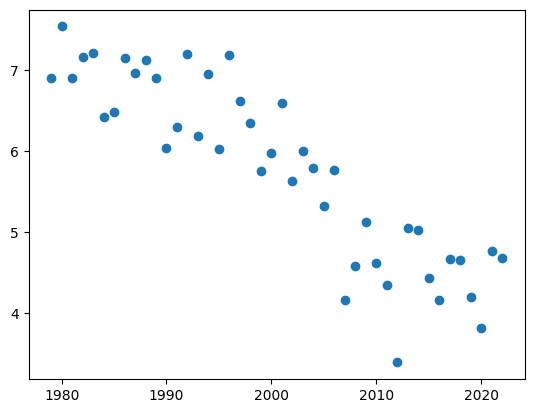

In [4]:
plt.scatter(data['year'], data['min']);

## Model

In [5]:
years = jnp.array(data['year']) - 2000
mins  = jnp.array(data['min'])

In [6]:
def curve_fit(year, value):
    a = numpyro.sample("a", dist.Normal(5.5, 2))
    b = numpyro.sample("b", dist.HalfNormal(1)) 
    σ = numpyro.sample("σ", dist.HalfNormal(1))

    with numpyro.plate("lm", len(year)):
        numpyro.sample("obs", dist.Normal(a - b * year, σ), obs = value)

    v2023 = numpyro.sample("v2023", dist.Normal(a - b * 23, σ))  
    

In [7]:
kernel = NUTS(curve_fit)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(rng_key_, years, mins)

sample: 100%|██████████| 3000/3000 [00:06<00:00, 488.42it/s, 7 steps of size 6.50e-01. acc. prob=0.93]


In [8]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      5.82      0.08      5.81      5.69      5.96   1815.97      1.00
         b      0.08      0.01      0.08      0.07      0.09   2325.00      1.00
     v2023      4.00      0.56      4.01      3.04      4.86   1902.10      1.00
         σ      0.54      0.06      0.53      0.44      0.64   1285.83      1.00

Number of divergences: 0


In [9]:
samples = mcmc.get_samples()

In [10]:
v2012 = data['min'].min()
v2022 = data[data.year == 2022]['min'].min()
v2012, v2022

(3.387, 4.674)

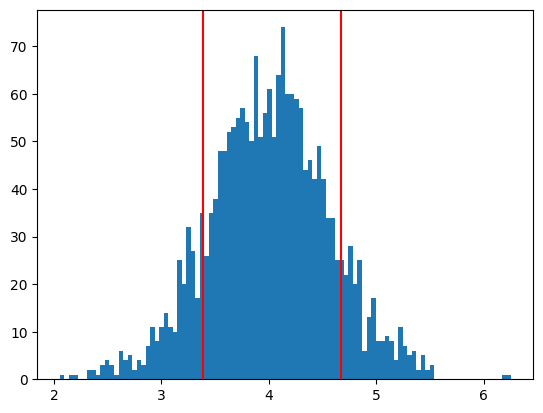

In [11]:
plt.hist(samples['v2023'], bins = 100)
plt.axvline(x = v2012, color = 'red')
plt.axvline(x = v2022, color = 'red');

In [12]:
p0 = (samples['v2023'] < v2012).mean()
p2 = (samples['v2023'] > v2022).mean()
p1 = 1 - p0 - p2

In [13]:
p0, p1, p2

(Array(0.132, dtype=float32),
 Array(0.75450003, dtype=float32),
 Array(0.11350001, dtype=float32))